In [1]:
from runSim import run_sim
import time
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt


In [8]:
#Number of different number of nodes points (each simulation takes one different)
nNodes_points = 50
#Mininum amount of nodes
nNodes_min = 1000
#Maximum amount of nodes
nNodes_max = 200000
#Number of nodes is divided by 8, as we are simulating one of the 8 grid.
#As they are random selected, it is a very good approximation to consider one of them only, and it decreases the simulation time.
#In the end, we multiply this array by 8 if we want to consider the technology total capacity.
nNodes = np.linspace(nNodes_min, nNodes_max, nNodes_points, dtype=int)//8
#Simulation time in seconds
simTime = 60*60
#Number of simulation loops for each configuration.
loops = 2

start = time.perf_counter()
success = []
#For each number of nodes point, run the simulation "loops" times
for n in nNodes:
    #This line runs the simulation loops in paralel, using n_jobs as the number of threads generated.
    #Consider using a number according to the amount of reseources available to your machine to avoid crashing your system.
    results = Parallel(n_jobs=2) (delayed(run_sim)(n, simTime, seed) for seed in range(0,loops))
    #At the moment we only get the network outage probability as results and append the mean of the loops (for better accuracy) to a list.
    success.append(np.mean(results))

print(f"The simulation lasted {time.perf_counter()-start} seconds.")


The simulation lasted 1423.3415066000307 seconds.


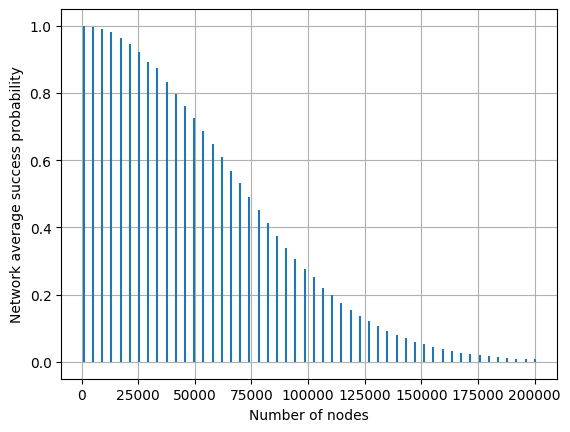

In [9]:
#Just a very simple vertical line plot
plt.vlines(nNodes*8, ymin = 0, ymax = success)
plt.grid()
plt.xlabel("Number of nodes")
plt.ylabel("Network average success probability")
plt.show()

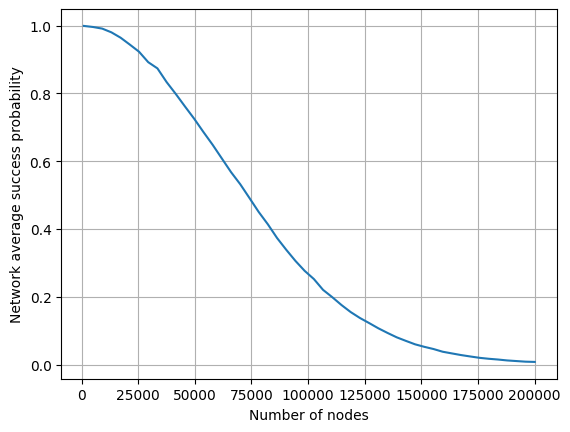

In [10]:
#Another example of plot, now making it an interpolated line between the points

plt.plot(nNodes*8, success)
plt.grid()
plt.xlabel("Number of nodes")
plt.ylabel("Network average success probability")
plt.show()